# **Isolated Forest Model - Anomaly Detection**
### Group 8


### **__Comments__**
- Percentile for thresholding used 0.25th, this will be changed in the future as the logs will be scored

- **Model without finetuning or proper way of being evaluated**

- Needs more features and to learn how to use Coordinates & IPs

- Dataset was split into 85:15 training to test data and inside training data 80:20 training to validation data

- The test set was not used

- The main problem we have is the lack of features as I don't think enough 'hidden relationships' are being seen which would explain the results


### **Data loading and Explotarion**

In [256]:
# Libraries
import json
from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [257]:
# Dataloading
features = open("features.json",)
data_dict=json.load(features)

In [258]:
# Dataframe
l_ip=[]
l_coord=[]
l_time=[]
l_inst=[]
l_url=[]
l_response=[]
l_weight=[]
for i in data_dict.keys():
    for log in data_dict[i]:
        l_ip.append(i)
        l_coord.append(log["coords"])
        l_time.append(log["log_time"])
        l_inst.append(log["instruction"])
        l_url.append(log["url"])
        l_response.append(log["response"])
        l_weight.append(log["response_weight"])

In [259]:
# Removing minutes and seconds from time (this is a simplification, will be changed in the future)
for i in range(len(l_time)):
    l_time[i]=l_time[i][0]

In [260]:
# Dataframe and data exploration
l_ip=pd.Series(l_ip)
l_coord=pd.Series(l_coord)
l_time=pd.Series(l_time)
l_inst=pd.Series(l_inst)
l_url=pd.Series(l_url)
l_response=pd.Series(l_response)
l_weight=pd.Series(l_weight)

# Example of data
print(l_ip[0]) # 35.170.74.25
print(l_coord[0]) # [40.7128, -74.0060]
print(l_time[0]) # 18
print(l_inst[0]) # GET
print(l_url[0]) # /fr/que-faire/que-fer-sitges-de-nit.htm HTTP/2.0
print(l_response[0]) # 200
print(l_weight[0]) # 9037


print(l_ip.dtype) # object
print(l_coord.dtype) # object
print(l_time.dtype) # int64
print(l_inst.dtype) # object
print(l_url.dtype) # object
print(l_response.dtype) # object
print(l_weight.dtype) # object


35.170.74.25
[39.0438, -77.4874]
18
GET
/fr/que-faire/que-fer-sitges-de-nit.htm HTTP/2.0
200
9037
object
object
int64
object
object
object
object


In [261]:
# Dataframe creation
frame = {"IP": l_ip,"Coordinates":l_coord,"Time":l_time,"Instruction":l_inst,"URL":l_url,"Response":l_response,"Weight":l_weight}
data=DataFrame(frame)

In [262]:
# Data exploration
data

,IP,Coordinates,Time,Instruction,URL,Response,Weight
0,35.170.74.25,"[39.0438, -77.4874]",18,GET,/fr/que-faire/que-fer-sitges-de-nit.htm HTTP/2.0,200,9037
1,54.36.148.248,"[50.6917, 3.20157]",0,GET,/nl/pl349/nieuws/nieuws/id560/fitur-marca-el-t...,200,10946
2,54.36.148.248,"[50.6917, 3.20157]",0,GET,/es/pl330/actualidad/agenda/id252/teatre-music...,200,11202
3,54.36.148.248,"[50.6917, 3.20157]",0,GET,/es/pl415/blog/llistat-blog/id23/las-casitas-e...,200,11190
4,54.36.148.248,"[50.6917, 3.20157]",1,GET,/es/pl349/actualidad/noticias/id305/sitges-cel...,200,10954
...,...,...,...,...,...,...,...
143725,111.7.100.31,"[22.5431, 114.058]",5,GET,/plantilles/turisme/js/calendar.js HTTP/1.1,200,8727
143726,111.7.100.31,"[22.5431, 114.058]",5,GET,/comu/js/cookiemanager.js HTTP/1.1,200,7325
143727,81.246.220.133,"[50.4102, 4.4472]",23,GET,/media/site1/cache/images/montserrat.jpg HTTP/2.0,200,191129
143728,162.216.150.71,"[32.8771, -80.013]",17,GET,/ HTTP/1.1,301,537


### **Pipeline Creation**

In [263]:

# WE ARE NOT USING IP OR COORDINATES FOR NOW (until we figure out how to use them)
#data = data.drop(columns=["IP", "Coordinates"])

# Data cleaning

# Define categorical and numerical features
categorical_features = ["Instruction", "URL", "Response"]
numerical_features = ["Time", "Weight"]

# Create a pipeline
# Define preprocessing steps with handle_unknown='ignore' (to ignore new categories in the test set, also to fix errors and be able to use said pipeline)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [264]:
# Define Isolation Forest model
model = IsolationForest()

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

In [265]:
# Data split

# Split data into train and test sets (85:15)
X_train, X_test = train_test_split(data, test_size=0.15, random_state=42)

# Split training data into train and validation sets (80:20)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [266]:
# Train the model
pipeline.fit(X_train)

# Predict anomaly scores on the validation set
validation_scores = pipeline.named_steps['model'].decision_function(pipeline.named_steps['preprocessor'].transform(X_val))

print("Validation Scores:", validation_scores)

Validation Scores: [0.20570649 0.19642015 0.19487157 ... 0.18922576 0.19327198 0.18838718]


### **Visualization**

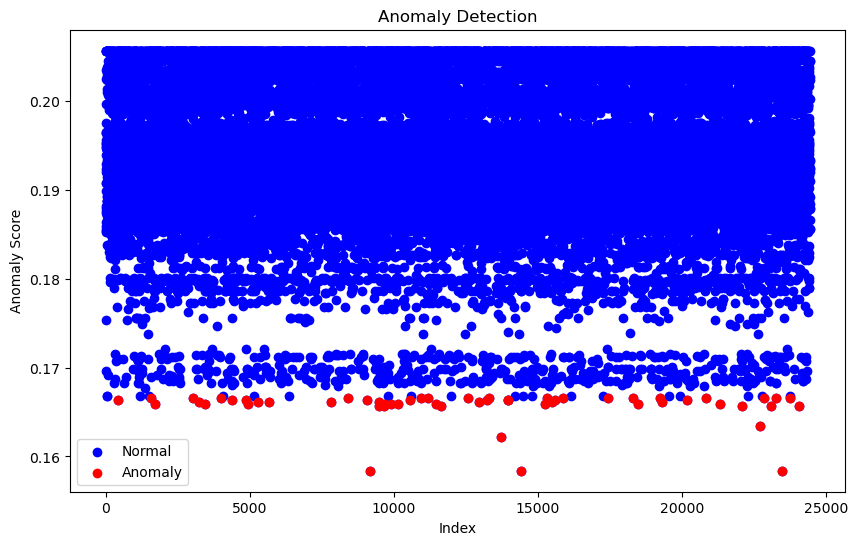

In [267]:
# Identify anomalies
threshold = np.percentile(validation_scores, 0.25)  # Define a threshold to identify anomalies 0.25th percentile (makes sense in something like logs)
# This will be changed in future as logs will be given a score not a threshold/percentile
anomalies_indices = np.where(validation_scores < threshold)[0]
anomalies_scores = validation_scores[validation_scores < threshold]

# Plot anomaly scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(validation_scores)), validation_scores, color='blue', label="Normal")
plt.scatter(anomalies_indices, anomalies_scores, color='red', label="Anomaly")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Detection")
plt.legend()
plt.show()

/Users/marino/miniconda3/envs/collegeEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


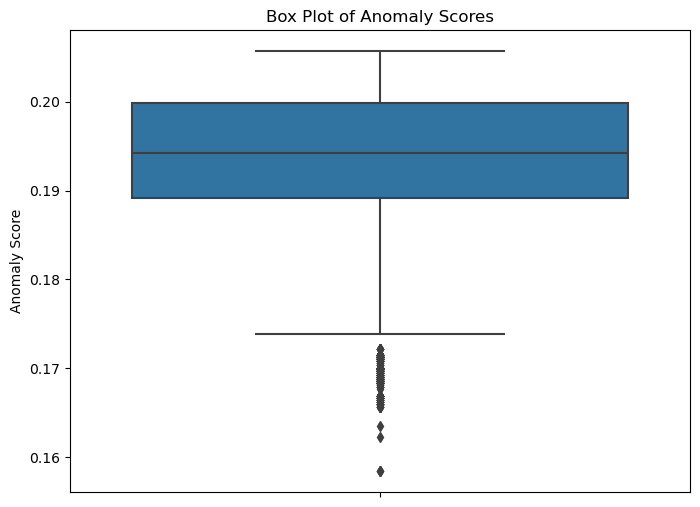

In [268]:
# Create a box plot of anomaly scores
plt.figure(figsize=(8, 6))
sns.boxplot(y=validation_scores)
plt.ylabel("Anomaly Score")
plt.title("Box Plot of Anomaly Scores")
plt.show()